# Predict ETH price direction - Random Forest Classifier

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime 

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_6.csv', parse_dates=True)

In [3]:
# Read in combined ETH Google trends data
eth_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_google_trends/eth_trends_combined.csv', parse_dates=True)
eth_google_trends.reset_index(inplace=True)
eth_google_trends.rename(columns={'date':'time', 'ethereum':'ETH_Trends'},inplace=True)
eth_google_trends = eth_google_trends.drop(columns='index')
eth_google_trends['time'] = pd.to_datetime(eth_google_trends['time']).dt.date
eth_google_trends = eth_google_trends.set_index('time')
eth_google_trends.tail()

,ETH_Trends
time,
2021-07-08,21
2021-07-09,21
2021-07-10,16
2021-07-11,15
2021-07-12,18


In [4]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
188,2021-07-08 00:00:00+00:00,eth,590368,1.508218,2.470993e+11,487.562763,26.174093,2118.924331,1.166154e+08,1262627,9.440605e+09,22.200455
189,2021-07-09 00:00:00+00:00,eth,595204,1.528143,2.511920e+11,485.362057,35.690899,2153.773738,1.166288e+08,1223691,7.037984e+09,22.216806
190,2021-07-10 00:00:00+00:00,eth,546313,1.507265,2.469390e+11,503.737633,46.026242,2117.063967,1.166422e+08,1139265,5.365179e+09,22.223583
191,2021-07-11 00:00:00+00:00,eth,579907,1.520469,2.496654e+11,499.343026,93.072929,2140.192887,1.166556e+08,1101766,2.682471e+09,22.224362
192,2021-07-12 00:00:00+00:00,eth,552707,1.469284,2.371913e+11,503.391952,34.003743,2033.031335,1.166688e+08,1191465,6.975448e+09,22.241962


In [5]:
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [6]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
time,,,,,,,,,,,
2021-07-08,eth,590368,1.508218,2.470993e+11,487.562763,26.174093,2118.924331,1.166154e+08,1262627,9.440605e+09,22.200455
2021-07-09,eth,595204,1.528143,2.511920e+11,485.362057,35.690899,2153.773738,1.166288e+08,1223691,7.037984e+09,22.216806
2021-07-10,eth,546313,1.507265,2.469390e+11,503.737633,46.026242,2117.063967,1.166422e+08,1139265,5.365179e+09,22.223583
2021-07-11,eth,579907,1.520469,2.496654e+11,499.343026,93.072929,2140.192887,1.166556e+08,1101766,2.682471e+09,22.224362
2021-07-12,eth,552707,1.469284,2.371913e+11,503.391952,34.003743,2033.031335,1.166688e+08,1191465,6.975448e+09,22.241962


In [7]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,eth_google_trends],axis=1).dropna()
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends
time,,,,,,,,,,,,
2021-07-08,eth,590368,1.508218,2.470993e+11,487.562763,26.174093,2118.924331,1.166154e+08,1262627,9.440605e+09,22.200455,21
2021-07-09,eth,595204,1.528143,2.511920e+11,485.362057,35.690899,2153.773738,1.166288e+08,1223691,7.037984e+09,22.216806,21
2021-07-10,eth,546313,1.507265,2.469390e+11,503.737633,46.026242,2117.063967,1.166422e+08,1139265,5.365179e+09,22.223583,16
2021-07-11,eth,579907,1.520469,2.496654e+11,499.343026,93.072929,2140.192887,1.166556e+08,1101766,2.682471e+09,22.224362,15
2021-07-12,eth,552707,1.469284,2.371913e+11,503.391952,34.003743,2033.031335,1.166688e+08,1191465,6.975448e+09,22.241962,18


In [8]:
combined_df.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_metrics_combined.csv')

<AxesSubplot:title={'center':'EMA ETH'}, xlabel='time', ylabel='ETH Price ($)'>

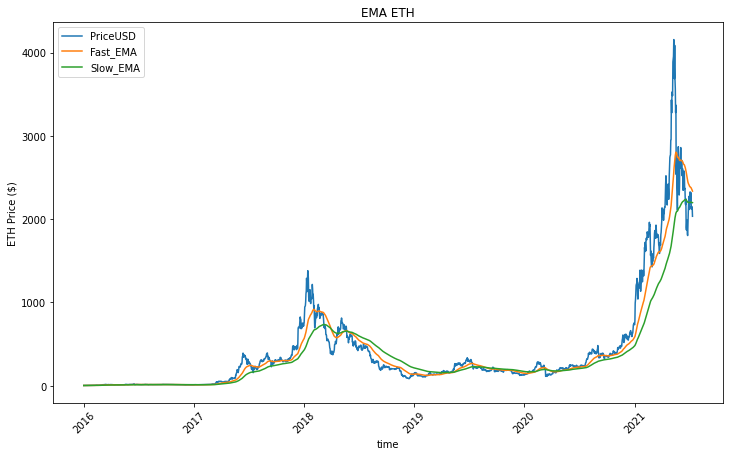

In [10]:
# Set short and long windows for EMA (Exponential Moving Average)
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
combined_df['Fast_EMA'] = combined_df['PriceUSD'].ewm(halflife=short_window).mean()
combined_df['Slow_EMA'] = combined_df['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
combined_df[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA ETH', ylabel='ETH Price ($)', rot=45) 

In [11]:
# Construct a crossover trading signal
combined_df['Crossover_Long'] = np.where(combined_df['Fast_EMA'] > combined_df['Slow_EMA'], 1.0, 0.0)
combined_df['Crossover_Short'] = np.where(combined_df['Fast_EMA'] < combined_df['Slow_EMA'],-1.0, 0.0)
combined_df['Crossover_Signal'] = combined_df['Crossover_Long'] + combined_df['Crossover_Short']

In [12]:
# Calculate daily return
combined_df['Daily_Return'] = combined_df['PriceUSD'].pct_change()

In [13]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
combined_df['Positive_Return'] = np.where(combined_df['Daily_Return'] > 0, 1.0, 0.0)

combined_df = combined_df.dropna()

# Convert date to str to set test and train windows 
combined_df.index = pd.to_datetime(combined_df.index, format = '%Y/%m/%d')
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,,
2016-01-02,eth,2486,2.226491,7.238322e+07,0.480767,370.221897,0.949990,7.619366e+07,9164,195513.065884,1.365054,4,0.935437,0.935283,1.0,0.0,1.0,0.032183,1.0
2016-01-03,eth,2528,2.238090,7.294862e+07,0.494175,234.211669,0.957063,7.622134e+07,9258,311464.489292,1.369430,4,0.942897,0.942644,1.0,0.0,1.0,0.007445,1.0
2016-01-04,eth,2623,2.222385,7.243632e+07,0.491670,626.141010,0.950000,7.624876e+07,9474,115686.914897,1.370961,5,0.944766,0.944521,1.0,0.0,1.0,-0.007380,0.0
2016-01-05,eth,2620,2.207573,7.189832e+07,0.492788,111.469298,0.942600,7.627660e+07,16430,645005.606026,1.384049,8,0.944302,0.944126,1.0,0.0,1.0,-0.007789,0.0
2016-01-06,eth,2743,2.227748,7.248901e+07,0.496250,159.111072,0.950000,7.630422e+07,17074,455587.485546,1.390600,8,0.945336,0.945139,1.0,0.0,1.0,0.007851,1.0


In [36]:
# Select model features and timeframe for train data
X = combined_df[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','ETH_Trends']]
X_train = X.loc[:'2020']

In [37]:
# Select prediction variable and timeframe for train data
y = combined_df['Positive_Return']
y_train = y[:'2020']

In [38]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [39]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [40]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [41]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
# Create the decision tree classifier instance and calculate the optimal tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.525179 using {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}


In [42]:
# Define the model using optimized settings
model = RandomForestClassifier(criterion='gini', max_depth=5,n_estimators=20, n_jobs=-1)

In [43]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [45]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [46]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [47]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2,84
Actual 1,1,106


Accuracy Score : 0.5595854922279793
Classification Report
              precision    recall  f1-score   support

         0.0       0.67      0.02      0.04        86
         1.0       0.56      0.99      0.71       107

    accuracy                           0.56       193
   macro avg       0.61      0.51      0.38       193
weighted avg       0.61      0.56      0.42       193



In [ ]:
# I will try to increase predictive ability of the model by excluding certain features or adding new ones and with further hyperparameter tuning. High recall (.99) with positive return prediction would allow for false positives to slip by, which could lead to financial loss. I would prefer false negative over false positive return prediction here.

In [48]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-06-23,1.0,1.0
2021-06-24,1.0,1.0
2021-06-25,0.0,1.0
2021-06-26,0.0,1.0
2021-06-27,1.0,1.0
2021-06-28,1.0,1.0
2021-06-29,1.0,1.0
2021-06-30,1.0,1.0
2021-07-01,0.0,1.0


In [49]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)[:10]

[(0.16975340384295687, 'CapMVRVCur'),
 (0.1554521314699535, 'VelCur1yr'),
 (0.12665979783292, 'CapMrktCurUSD'),
 (0.1088363289021, 'TxCnt'),
 (0.10706633238703063, 'AdrActCnt'),
 (0.10651506645617466, 'HashRate'),
 (0.086527867473297, 'TxTfrValAdjUSD'),
 (0.08028322369662112, 'NVTAdj'),
 (0.05434485053867817, 'ETH_Trends'),
 (0.004560997400268029, 'Crossover_Signal')]

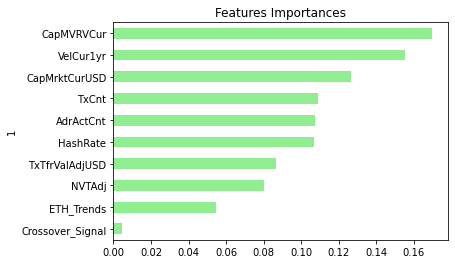

In [50]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))[:10]
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

## Modified RF Classifier 
### Hyperparameter tuning and feature combinations to improve predictive ability of the classification model

In [71]:
# Select model features and timeframe for train data
X = combined_df[['CapMVRVCur']]
X_train = X.loc[:'2020']
y = combined_df['Positive_Return']
y_train = y[:'2020']
X_test = X['2021':]
y_test = y['2021':]
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [82]:
# Define the model using modified settings
model = RandomForestClassifier(criterion='entropy', max_depth=5,n_estimators=20, n_jobs=-1)

In [83]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [84]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [85]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [81]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,19,67
Actual 1,11,96


Accuracy Score : 0.5958549222797928
Classification Report
              precision    recall  f1-score   support

         0.0       0.63      0.22      0.33        86
         1.0       0.59      0.90      0.71       107

    accuracy                           0.60       193
   macro avg       0.61      0.56      0.52       193
weighted avg       0.61      0.60      0.54       193



In [ ]:
# Reducing number of features to one most important, it appears the RF model predicts better negative return in the original and modified model. High recall score of positive prediction would allow false positives and potential financial loss. 